In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

import torch  # PyTorch deep learning library
import torch.nn as nn  # Neural network module in PyTorch
from torch.utils.data import DataLoader  # DataLoader for handling datasets in PyTorch
from torchvision import datasets, transforms  # Modules for loading datasets and image transformations
import matplotlib.pyplot as plt  # Matplotlib's plotting module
import numpy as np  # NumPy for numerical computing
import itertools  # Standard library module for creating iterators

import time  # Standard library module for time-related tasks
from matplotlib.animation import FuncAnimation  # For creating animations in Matplotlib
from IPython.display import Image  # For displaying images within the IPython environment

# Importing libraries for data splitting and handling
from sklearn.model_selection import train_test_split  # Function for splitting datasets
import pandas as pd  # Pandas for data manipulation and analysis
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tensorflow.keras.applications import DenseNet121

TensorFlow version: 2.15.0
Keras version: 3.2.1


In [73]:
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [74]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7befbdb6-8c52-8534-66f2-cd47fbd29a73)
GPU 1: Tesla T4 (UUID: GPU-b58ca66f-44b1-73f6-c880-4b43e5069ce6)


In [75]:
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input


# Define batch size, image sizes, and paths
BATCH_SIZE = 16
IMG_HEIGHT = 800
IMG_WIDTH = 1200
train_dir = '/kaggle/input/pnemonia/train/train'  # Update with your actual paths
val_dir = '/kaggle/working/validation_data'  # New directory for validation data
test_dir = '/kaggle/input/pnemonia/test/test'  # Update with your actual paths

# Create the validation directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# Function to create dataframe from file paths
def create_dataframe(directory):
    file_paths = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # Assuming directory names are class labels
    df = pd.DataFrame({'file_paths': file_paths, 'labels': labels})
    return df

# Create dataframes for each directory
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)  # Updated to use the validation directory
test_df = create_dataframe(test_dir)

# Split training set into training and validation
train_files, val_files = train_test_split(train_df, test_size=0.2, random_state=42)

# Move some training files to validation directory
for index, row in val_files.iterrows():
    src = row['file_paths']
    dst = os.path.join(val_dir, row['labels'], os.path.basename(src))
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(src, dst)  # Using copy instead of move

# Define image data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input  # Assuming preprocess_input is defined
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_files,
    x_col='file_paths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_files,  # Changed to use val_files DataFrame
    x_col='file_paths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_paths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [76]:
# Load the DenseNet121 model with pretrained weights
densenet_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(800,1200,3))

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 562ms/step
Validation F1-score: 0.8445
Confusion Matrix:
[[161 130]
 [ 20 733]]
Validation F1-score improved. Saving weights.


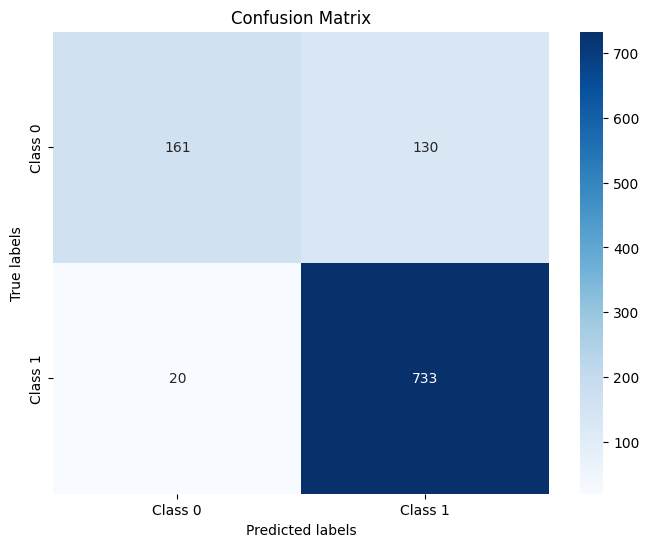

261/261 ━━━━━━━━━━━━━━━━━━━━ 255s 946ms/step - accuracy: 0.7419 - loss: 0.5983 - val_accuracy: 0.8563 - val_loss: 0.5419
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step
Validation F1-score: 0.6506
Confusion Matrix:
[[291   0]
 [376 377]]


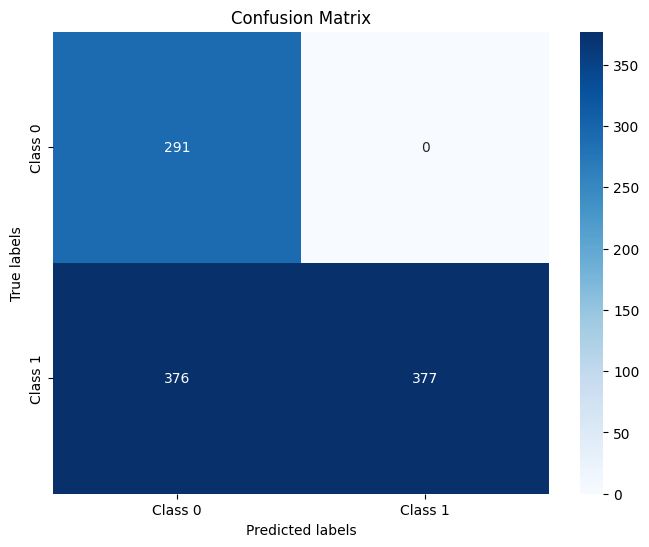

261/261 ━━━━━━━━━━━━━━━━━━━━ 248s 935ms/step - accuracy: 0.7992 - loss: 0.3750 - val_accuracy: 0.6398 - val_loss: 4.2710
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step
Validation F1-score: 0.7551
Confusion Matrix:
[[290   1]
 [268 485]]


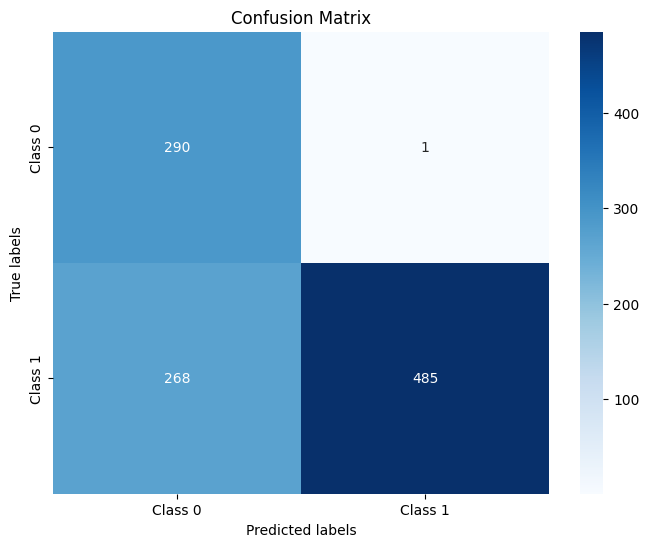

261/261 ━━━━━━━━━━━━━━━━━━━━ 248s 932ms/step - accuracy: 0.9525 - loss: 0.1798 - val_accuracy: 0.7423 - val_loss: 11.7626
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 572ms/step - accuracy: 0.9107 - loss: 0.5143
Test Loss: 0.6029, Test Accuracy: 0.6667


In [77]:
import tensorflow.keras as keras
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom callback to compute F1-score and confusion matrix
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.best_f1_score = 0
        self.best_weights = None
        self.cm = None  # Confusion matrix

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.validation_data.labels
        y_pred = self.model.predict(self.validation_data)
        y_pred = np.argmax(y_pred, axis=1)
        
        # Compute F1-score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f'Validation F1-score: {f1:.4f}')
        
        # Compute confusion matrix
        self.cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:")
        print(self.cm)
        
        # Save the weights if the F1-score improves
        if f1 > self.best_f1_score:
            print("Validation F1-score improved. Saving weights.")
            self.best_f1_score = f1
            self.best_weights = self.model.get_weights()

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

# Load pretrained DenseNet121 model
pretrained_model = keras.applications.DenseNet121(weights='imagenet', include_top=False)

# Freeze layers beyond the first 10 layers
for layer in pretrained_model.layers[0:13]:
    layer.trainable = False
    
for layer in pretrained_model.layers[14:20]:
    layer.trainable = True

# Create custom model
x = pretrained_model.layers[20].output  # Output of the 10th layer
x = keras.layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D to ensure output shape is fully defined
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)  # Add custom Dense layer
predictions = keras.layers.Dense(2, activation='softmax')(x)  # Output layer
custom_model = keras.models.Model(inputs=pretrained_model.input, outputs=predictions)

# Define your desired learning rate
learning_rate = 0.0001  # Example learning rate

# Create an instance of the Adam optimizer with the desired learning rate
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
custom_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)
f1_score_callback = F1ScoreCallback(val_generator)

# Train the model
custom_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, f1_score_callback])

# Load the best weights
custom_model.set_weights(f1_score_callback.best_weights)

# Evaluate the model on the test set
test_loss, test_accuracy = custom_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.9107 - loss: 0.5143
Test Loss: 0.6029, Test Accuracy: 0.6667
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step
Confusion Matrix (Test Set):
[[ 30 204]
 [  4 386]]
Precision (Test Set): 0.6542
Recall (Test Set): 0.9897
F1-Score (Test Set): 0.7878


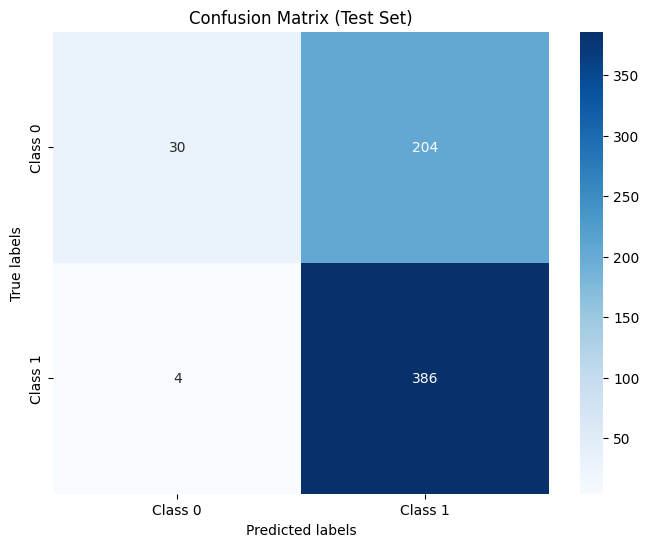

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model on the test set
test_loss, test_accuracy = custom_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels for the test set
y_true_test = test_generator.labels
y_pred_test = custom_model.predict(test_generator)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Compute confusion matrix for the test set
cm_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix (Test Set):")
print(cm_test)

# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = f1_score(y_true_test, y_pred_test)

print(f"Precision (Test Set): {precision_test:.4f}")
print(f"Recall (Test Set): {recall_test:.4f}")
print(f"F1-Score (Test Set): {f1_test:.4f}")

# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()
